<a href="https://colab.research.google.com/github/rroxy08/CE888/blob/master/assignment1/covariate_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random as rd
from scipy.ndimage.filters import gaussian_filter
from sklearn.neighbors import KernelDensity
import os
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import scipy.stats  as stats
from scipy.stats import norm
from sklearn.metrics import accuracy_score

#drive.mount('/content/gdrive')
os.environ['KAGGLE_USERNAME'] = "khaledabegum"
os.environ['KAGGLE_KEY'] = "d51b08acbd052ca7a4b2f21e76aa0e6f"


In [41]:
#!kaggle competitions download -c santander-customer-transaction-prediction
!kaggle competitions download --force -c porto-seguro-safe-driver-prediction

  0% 0.00/2.12M [00:00<?, ?B/s]
100% 2.12M/2.12M [00:00<00:00, 69.4MB/s]
 57% 17.0M/30.0M [00:00<00:00, 172MB/s]
100% 30.0M/30.0M [00:00<00:00, 146MB/s]
 92% 41.0M/44.4M [00:01<00:00, 16.8MB/s]
100% 44.4M/44.4M [00:01<00:00, 27.1MB/s]


In [42]:
from zipfile import ZipFile

file_names = ["/content/train.csv.zip","/content/test.csv.zip"]
for file_name in file_names:
  with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('done')

done
done


In [0]:
root_path1 = '/content/train.csv' 
root_path2 = '/content/test.csv' 
df_train=pd.read_csv(root_path1)
df_test=pd.read_csv(root_path2)
#df_tr=df_train.sample(10000)
#if "socialEngagementType" in df_tr.columns:
  #del df_tr["socialEngagementType"]
df_tr=df_train.copy()
df_ts=df_test.copy()
#df_tr.head(10)
#df_tr['target'].value_counts()

In [44]:
#df_tr.head()
df_tr.shape

#df_tr[['full_sq','raion_popul']].plot.hist()
#df_ts[['full_sq','raion_popul']].plot.hist()
#df_ts.dtypes

(595212, 59)

In [45]:
for i in df_tr.columns:
    if (df_tr[i].dtype == 'object'):
      df_tr[i] = df_tr[i].fillna(df_tr[i].mode().iloc[0])
    if (df_tr[i].dtype == 'int'or df_tr[i].dtype == 'float'):
      df_tr[i] = df_tr[i].fillna(np.mean(df_tr[i]))

for i in df_ts.columns:
    if (df_ts[i].dtype == 'object'):
      df_ts[i] = df_ts[i].fillna(df_ts[i].mode().iloc[0])
    if (df_ts[i].dtype == 'int' or df_ts[i].dtype == 'float'):
      df_ts[i] = df_ts[i].fillna(np.mean(df_ts[i]))

## Label    encoding
number = LabelEncoder()
for i in df_tr.columns:
    if (df_tr[i].dtype == 'object'):
      df_tr[i] = number.fit_transform(df_tr[i].astype('str'))
      df_tr[i] = df_tr[i].astype('object')

for i in df_ts.columns:
    if (df_ts[i].dtype == 'object'):
      df_ts[i] = number.fit_transform(df_ts[i].astype('str'))
      df_ts[i] = df_ts[i].astype('object')

df_tr.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [46]:
#df_ts.head()
df_tr['target'].value_counts()

0    573518
1     21694
Name: target, dtype: int64

In [0]:
def return_intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
    return intersection
'''
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))
'''
def compute_kl_divergence(p,q):
    
    kl_div = 0.0
    len=np.size(p)
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
       
    for i in range(len):
      #p[i]=p[i]+0.00001
      #q[i]=q[i]+0.00001  
                     
      if(q[i]!=0.0 and p[i]!=0):
        kl_div+=p[i]*(np.log(p[i]/q[i]))                 
    return kl_div   

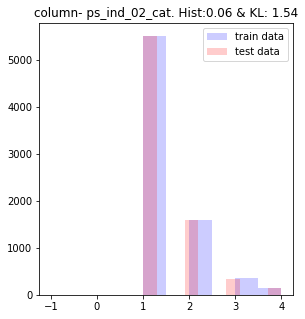

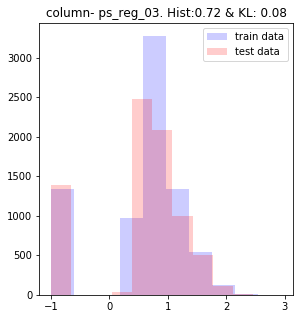

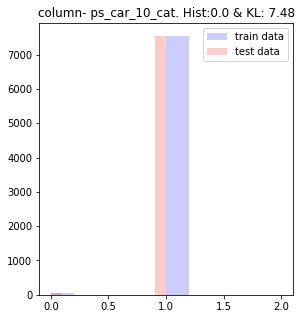

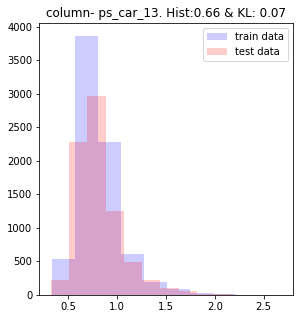

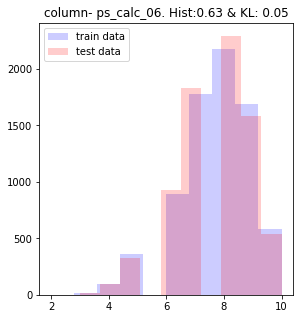

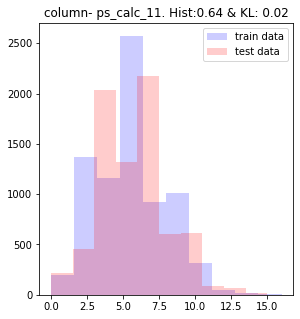

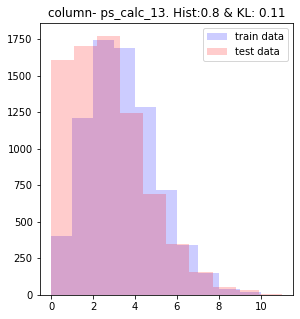

In [48]:
features= ['ps_ind_02_cat', 'ps_reg_03', 'ps_car_10_cat', 'ps_car_13', 'ps_calc_06', 'ps_calc_11', 'ps_calc_13']

training = df_tr.sample(7600, random_state=12) 
testing = df_ts.sample(7600,random_state=11) 

if('target' in training):
  del training['target']

if('id' in training):
  del training['id']

if('id' in testing):
  del testing['id']

bin_val = 10
i=0 
sigma=1

for col in training[features].columns: 
  hist_1, _ = np.histogram(training[col], bins=bin_val,density=True) 
  hist_2, _ = np.histogram(testing[col], bins=bin_val,density=True)
  
  #histpgram distribution 

  hist_r=hist_1/np.sum(hist_1)
  hist_s=hist_2/np.sum(hist_2)

  #Gaussian smoothing of histogram for non zero probability distribution

  asmooth, bsmooth = (gaussian_filter(hist_r, sigma),
                        gaussian_filter(hist_s,sigma))
  
  hist_val=return_intersection(hist_1, hist_2)
  kl_val= compute_kl_divergence(asmooth, bsmooth)
  #------------------------------------------------------------
  #------------------------------------------------------------
  
  fig = plt.figure(figsize=(10,5))
  ax1 = fig.add_subplot(121) 
  ax1.hist(training[col], bins=10, color='blue',label='train data',alpha=0.2) 
  ax1.hist(testing[col], bins=10, color='red',label='test data', alpha=0.2) 
 
    
  ax1.set_title('column- '+col+'. Hist:'+ str(round(hist_val,2))+' & KL: '+str(round(kl_val,2))) 
  ax1.legend()
  
  


In [49]:
data_shift_hist=[]
data_shift_kl2=[]
data_shift_kl=[]

bin_val=10

for col in training.columns : 
  hist_1, _ = np.histogram(training[col], bins=bin_val,density=True) 
  hist_2, _ = np.histogram(testing[col], bins=bin_val,density=True)
  
  hist_1=hist_1/np.sum(hist_1)
  hist_2=hist_2/np.sum(hist_2)
                                                        #Gaussian smoothing for non zero probability distribution
  asmooth, bsmooth = (gaussian_filter(hist_1, sigma),
                        gaussian_filter(hist_2, sigma))
 
  hist_val=return_intersection(hist_1, hist_2)
  kl_val= compute_kl_divergence(asmooth, bsmooth)
  
  if(hist_val<0.90):
    data_shift_hist.append(col)
  if(kl_val>0.02):
    data_shift_kl.append(col)
   
  
print("Total Columns with covariate shift (using Histogram intersection method) are: ",len(data_shift_hist),data_shift_hist)
print("Total Columns with covariate shift (KL divergence method) are: ",len(data_shift_kl),data_shift_kl)



Total Columns with covariate shift (using Histogram intersection method) are:  8 ['ps_ind_02_cat', 'ps_reg_03', 'ps_car_10_cat', 'ps_car_13', 'ps_calc_06', 'ps_calc_11', 'ps_calc_13', 'ps_calc_14']
Total Columns with covariate shift (KL divergence method) are:  8 ['ps_ind_02_cat', 'ps_reg_03', 'ps_car_10_cat', 'ps_car_13', 'ps_calc_06', 'ps_calc_11', 'ps_calc_13', 'ps_calc_14']


In [53]:
#building a learning model

y=df_tr['target']
y=y.sample(8000)
X=df_tr.copy()
X=X.sample(8000)

if('target'in X.columns):
  del X['target']
X_test=df_ts.copy()
X_test=X_test.sample(8000)
print(X.columns)
print(X_test.columns)

Index(['id', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtyp

In [58]:
# Building the model 
#extra_tree_forest = ExtraTreesClassifier(n_estimators =20,criterion ='entropy', max_features = 10) 
extra_tree_forest = RandomForestClassifier(n_estimators=50) 
# Training the model 
extra_tree_forest.fit(X, y)
y_pred=extra_tree_forest.predict(X_test)
val=extra_tree_forest.score(X_test,y)
score = accuracy_score(y,y_pred)
print("The learning accuracy:",score)

The learning accuracy: 0.962625


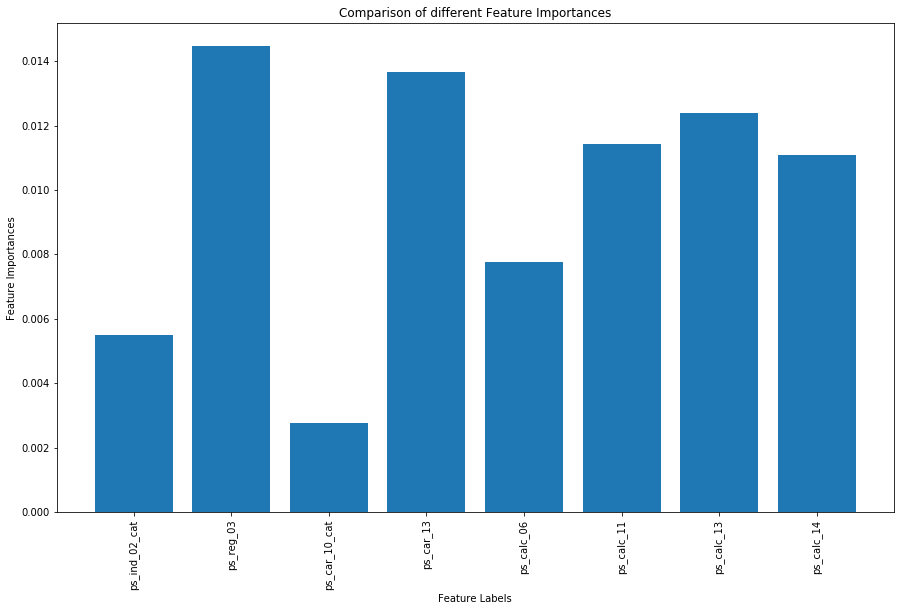

In [59]:
# Computing the importance of each feature 
feature_importance = extra_tree_forest.feature_importances_ 
  
# Normalizing the individual importances 
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        extra_tree_forest.estimators_], 
                                        axis = 0) 
imp_arr=[]
column_arr=[]

for i in range(len(data_shift_kl)):
  result = np.where(X.columns.values == data_shift_kl[i])
  
  j=result[0][0]
  imp_arr.append(feature_importance_normalized[j])

for item in X.columns:
  if(feature_importance_normalized[i]<0.005):
    column_arr.append(item)
#-------------------------------------------------------
# Plotting a Bar Graph to compare the models 
fig = plt.figure(figsize=(15,9))
plt.bar(data_shift_kl,imp_arr)
#plt.bar(X.columns, feature_importance_normalized)
plt.xlabel('Feature Labels') 
plt.ylabel('Feature Importances')
plt.xticks(rotation='vertical')
plt.title('Comparison of different Feature Importances') 

plt.show()


In [60]:
X_new=X.copy()
X_test_new=X_test.copy()
y_new=y.copy()

#--------------------------------------
for i in range(len(data_shift_kl)):
  
  if(imp_arr[i]<0.04):
    del X_new[data_shift_kl[i]]
    del X_test_new[data_shift_kl[i]]
#------------------------------------------
'''
for ftr in del_features:
  if(ftr in X_new.columns):
    del X_new[ftr]
    del X_test_new[ftr]
'''
#--------------------------------
# Training the model 
extra_tree_forest.fit(X_new, y_new)
y_pred=extra_tree_forest.predict(X_test_new)
score=accuracy_score(y_new,y_pred)
 
print(score)
  

0.962625
